In [1]:
import pandas as pd
import numpy as np
import warnings
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer
import evaluate
import wandb
import ast
warnings.filterwarnings("ignore")


train_data = pd.read_csv('train_data.csv')
train_data["label"] = train_data["target_labels_positions"].apply(
    lambda x: 1 if len(ast.literal_eval(x)) > 0 else 0
)
train_data

,processed_text,target_labels_positions,label
0,аа союзная тридцать пять дробь один лариса сое...,{},0
1,аа приложение мне показывает к оплате у меня п...,{},0
2,да лисное по призрак лишнее ну почему иду пять...,"{'I-value': [140], 'B-value': [139], 'B-discou...",1
3,а что добрый день NAME у меня пришел какой то ...,{'B-discount': [12]},1
4,у меня западный с утра да да еще да да самый в...,{},0
...,...,...,...
3394,а доброе утро меня заинтересовала ваш проект н...,"{'I-value': [224, 225], 'B-value': [223], 'B-d...",1
3395,здравствуйте меня зовут иван я бы хотел сегодн...,{},0
3396,целенаправлен на голосовой почтовый ящик вы мо...,{},0
3397,NAME зовут NAME я хотела уточнить ээ своего ме...,{},0


In [2]:
dataset = Dataset.from_pandas(train_data[train_data['label'] == 1])
dataset = dataset.shuffle()
dataset_train_test = dataset.train_test_split(test_size=0.1)

final_ds = DatasetDict(
    {
        "train": dataset_train_test["train"],
        "test": dataset_train_test["test"],
    }
)
final_ds

DatasetDict({
    train: Dataset({
        features: ['processed_text', 'target_labels_positions', 'label', '__index_level_0__'],
        num_rows: 452
    })
    test: Dataset({
        features: ['processed_text', 'target_labels_positions', 'label', '__index_level_0__'],
        num_rows: 51
    })
})

In [3]:
entity_groups = ["B-discount", "B-value", "I-value"]
entity_groups.insert(0, "O")
id2label = {i: label for i, label in enumerate(entity_groups)}
label2id = {v: k for k, v in id2label.items()}
num_labels = len(id2label)
label_list = list(label2id.keys())
id2label

{0: 'O', 1: 'B-discount', 2: 'B-value', 3: 'I-value'}

In [4]:
from nltk.tokenize import word_tokenize
def preprocess_text(example):

    words = []
    tags = []
    new_dict = {}
    labels_dict = ast.literal_eval(example['target_labels_positions'])
    tags_index_list = [i[0] for i in labels_dict.values()]
    for key, value in labels_dict.items():
        for i in value:
            new_dict[i] = key
    for index, i in enumerate(word_tokenize(example['processed_text'])):
        if index in tags_index_list:
            if new_dict[index] == 'B-discount':
                tags.append(1)    
                words.append(i)
            elif new_dict[index] == "B-value":
                tags.append(2)
                words.append(i)
            else:
                tags.append(3)
                words.append(i)
        else:
            tags.append(0)
            words.append(i)


    example["ner_tag"] = tags
    example["tokens"] = words
    return example

In [5]:
processed_dataset = final_ds.map(
    preprocess_text, remove_columns=["processed_text", "target_labels_positions"]
)
processed_dataset

Map:   0%|          | 0/452 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', '__index_level_0__', 'ner_tag', 'tokens'],
        num_rows: 452
    })
    test: Dataset({
        features: ['label', '__index_level_0__', 'ner_tag', 'tokens'],
        num_rows: 51
    })
})

In [6]:
zero = 0
non_zero = 0
for i in processed_dataset["train"]["ner_tag"]:
    for item in i:
        if item == 0:
            zero += 1
        else:
            non_zero += 1
print(zero)
print(non_zero)

133219
1085


In [7]:
tokenizer = AutoTokenizer.from_pretrained("ai-forever/ruBert-base")

In [8]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"], truncation=True, is_split_into_words=True, max_length=512
    )

    labels = []
    for i, label in enumerate(examples[f"ner_tag"]):
        word_ids = tokenized_inputs.word_ids(
            batch_index=i
        )  # Map tokens to their respective word.
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:  # Set the special tokens to -100.
            if word_idx is None:
                label_ids.append(-100)
            elif (
                word_idx != previous_word_idx
            ):  # Only label the first token of a given word.
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [9]:
tokenized_dataset = processed_dataset.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=["tokens", "ner_tag", "__index_level_0__", 'label'],
)
tokenized_dataset

Map:   0%|          | 0/452 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 452
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 51
    })
})

In [10]:
seqeval = evaluate.load("seqeval")


def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = seqeval.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

In [11]:
from transformers import DataCollatorForTokenClassification
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer

data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

In [12]:
import numpy as np
model = AutoModelForTokenClassification.from_pretrained(
    "ai-forever/ruBert-base", num_labels=num_labels, id2label=id2label, label2id=label2id
)

training_args = TrainingArguments(
    output_dir="token_class_model",
    learning_rate=5e-05,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=8,
    weight_decay=0.1,
    evaluation_strategy="epoch",
    push_to_hub=False,
    save_strategy="no",
    group_by_length=True,
    warmup_ratio=0.1,
    optim="adamw_torch",
    lr_scheduler_type="cosine",
    report_to="none",

)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()


Some weights of BertForTokenClassification were not initialized from the model checkpoint at ai-forever/ruBert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.05928918346762657, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.9913008294557961, 'eval_runtime': 0.8338, 'eval_samples_per_second': 61.164, 'eval_steps_per_second': 8.395, 'epoch': 1.0}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.014969849959015846, 'eval_precision': 0.5529411764705883, 'eval_recall': 0.5108695652173914, 'eval_f1': 0.5310734463276837, 'eval_accuracy': 0.9945377301234068, 'eval_runtime': 0.8711, 'eval_samples_per_second': 58.545, 'eval_steps_per_second': 8.036, 'epoch': 2.0}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.009390761144459248, 'eval_precision': 0.6936936936936937, 'eval_recall': 0.8369565217391305, 'eval_f1': 0.7586206896551725, 'eval_accuracy': 0.9963584867489379, 'eval_runtime': 0.8506, 'eval_samples_per_second': 59.96, 'eval_steps_per_second': 8.23, 'epoch': 3.0}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.009068856947124004, 'eval_precision': 0.6837606837606838, 'eval_recall': 0.8695652173913043, 'eval_f1': 0.7655502392344498, 'eval_accuracy': 0.9967630993323893, 'eval_runtime': 0.8856, 'eval_samples_per_second': 57.591, 'eval_steps_per_second': 7.905, 'epoch': 4.0}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.0091583002358675, 'eval_precision': 0.776595744680851, 'eval_recall': 0.7934782608695652, 'eval_f1': 0.7849462365591399, 'eval_accuracy': 0.9970328410546901, 'eval_runtime': 0.909, 'eval_samples_per_second': 56.104, 'eval_steps_per_second': 7.701, 'epoch': 5.0}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.008013573475182056, 'eval_precision': 0.8539325842696629, 'eval_recall': 0.8260869565217391, 'eval_f1': 0.8397790055248618, 'eval_accuracy': 0.9979769370827433, 'eval_runtime': 0.854, 'eval_samples_per_second': 59.719, 'eval_steps_per_second': 8.197, 'epoch': 6.0}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.008586699143052101, 'eval_precision': 0.8191489361702128, 'eval_recall': 0.8369565217391305, 'eval_f1': 0.8279569892473119, 'eval_accuracy': 0.9975723244992919, 'eval_runtime': 0.8452, 'eval_samples_per_second': 60.341, 'eval_steps_per_second': 8.282, 'epoch': 7.0}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.0086021414026618, 'eval_precision': 0.8191489361702128, 'eval_recall': 0.8369565217391305, 'eval_f1': 0.8279569892473119, 'eval_accuracy': 0.9975723244992919, 'eval_runtime': 0.9032, 'eval_samples_per_second': 56.468, 'eval_steps_per_second': 7.751, 'epoch': 8.0}
{'train_runtime': 142.7066, 'train_samples_per_second': 25.339, 'train_steps_per_second': 3.195, 'train_loss': 0.047166276396366585, 'epoch': 8.0}


TrainOutput(global_step=456, training_loss=0.047166276396366585, metrics={'train_runtime': 142.7066, 'train_samples_per_second': 25.339, 'train_steps_per_second': 3.195, 'total_flos': 656489350931040.0, 'train_loss': 0.047166276396366585, 'epoch': 8.0})

In [13]:
res = trainer.predict(tokenized_dataset["test"])
metrics = compute_metrics([res.predictions, res.label_ids])
predictions = res.predictions
labels = res.label_ids
predictions = np.argmax(predictions, axis=2)

true_predictions = [
    [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
true_labels = [
    [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

answers = pd.DataFrame(
    {
        "text": final_ds["test"]["processed_text"],
        "y_true": true_labels,
        "y_pred": true_predictions,
    }
)

answers["y_true"] = answers["y_true"].map(lambda x: ", ".join(i for i in x))
answers["y_pred"] = answers["y_pred"].map(lambda x: ", ".join(i for i in x))

  0%|          | 0/7 [00:00<?, ?it/s]

In [14]:
from sklearn.metrics import classification_report

print(
    classification_report(
        ", ".join(answers["y_true"]).split(", "),
        ", ".join(answers["y_pred"]).split(", "),
        labels=label_list,
    )
)

              precision    recall  f1-score   support

           O       1.00      1.00      1.00     14700
  B-discount       0.92      0.86      0.89        51
     B-value       0.80      0.88      0.84        41
     I-value       0.79      0.89      0.84        37

    accuracy                           1.00     14829
   macro avg       0.88      0.91      0.89     14829
weighted avg       1.00      1.00      1.00     14829



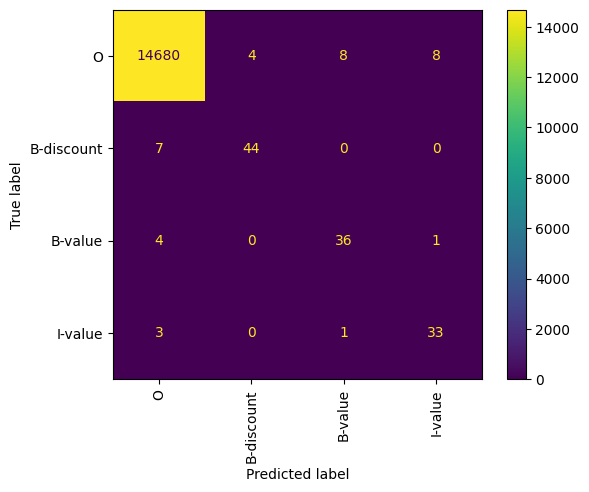

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
cm =  confusion_matrix( ", ".join(answers["y_true"]).split(", "),
    ", ".join(answers["y_pred"]).split(", "),
    labels=label_list)
cm_display = ConfusionMatrixDisplay(cm, display_labels=label_list)
cm_display.plot(xticks_rotation="vertical")
plt.show()

In [16]:
weights = {"B-discount": 1, "B-value": 2, "I-value": 2, "O": 0.003}

from sklearn.metrics import precision_recall_fscore_support


def weighted_f1(y_true, y_pred, weights):
    """Расчет взвешенной F1 меры с индивидуальными весами для классов."""

    # рассчитываем F1 для всех классов
    _, _, f1, support = precision_recall_fscore_support(
        y_true, y_pred, average=None, labels=list(weights.keys())
    )

    # вычисление взвешенной F-меры
    weighted_f1 = np.sum(
        f1 * [weights[label] for label in np.unique(y_true + y_pred)] * support
    ) / np.sum(support * [weights[label] for label in np.unique(y_true + y_pred)])
    return weighted_f1


weighted_f1_score = weighted_f1(
    ", ".join(answers["y_true"]).split(", "),
    ", ".join(answers["y_pred"]).split(", "),
    weights,
)
print(weighted_f1_score)

0.8755725628190753
